In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

# Load dataset (replace 'online_retail.xlsx' with your file path)
df = pd.read_csv('/content/drive/MyDrive/CSV files/Online Retail.csv',encoding='latin-1')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [33]:
# Data cleaning
df = df.dropna(subset=['StockCode', 'Quantity', 'InvoiceDate', 'UnitPrice'])
df = df[df['Quantity'] > 0]  # Remove returns
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M', errors='coerce')
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate daily demand by product
daily_demand = df.groupby(['StockCode', df['InvoiceDate'].dt.date])['Quantity'].sum().reset_index()
daily_demand

,StockCode,InvoiceDate,Quantity
0,10002,2010-12-01,60
1,10002,2010-12-02,1
2,10002,2010-12-03,8
3,10002,2010-12-05,1
4,10002,2010-12-06,25
...,...,...,...
276838,gift_0001_50,2010-12-23,1
276839,gift_0001_50,2011-05-06,1
276840,gift_0001_50,2011-06-24,1
276841,gift_0001_50,2011-06-30,1


In [34]:
# Filter products with sufficient data (at least 10 days of sales)
product_counts = daily_demand.groupby('StockCode').size()
valid_products = product_counts[product_counts >= 10].index
daily_demand = daily_demand[daily_demand['StockCode'].isin(valid_products)]

# Select top-selling product (by total quantity)
top_product = daily_demand.groupby('StockCode')['Quantity'].sum().idxmax()
top_product

'23166'

In [35]:
product_data = daily_demand[daily_demand['StockCode'] == top_product]

# Handle outliers (remove quantities > 99th percentile)
quantity_threshold = product_data['Quantity'].quantile(0.99)
product_data = product_data[product_data['Quantity'] <= quantity_threshold]

# Calculate mean and standard deviation
mean_demand = product_data['Quantity'].mean()
std_demand = product_data['Quantity'].std()

print(f"Product: {top_product}, Mean Daily Demand: {mean_demand:.2f}, Std Dev: {std_demand:.2f}")

Product: 23166, Mean Daily Demand: 28.69, Std Dev: 41.44


In [37]:
# Parameters
D = mean_demand * 365  # Annual demand
S = 100  # Ordering cost
H = 0.50  # Holding cost per unit per year
L = 5  # Lead time in days
z = 1.645  # z-score for 95% service level

# EOQ calculation
Q = np.sqrt((2 * D * S) / H)

# Safety stock and reorder point
safety_stock = z * std_demand * np.sqrt(L)
rop = (mean_demand * L) + safety_stock

print(f"Optimal Order Quantity (EOQ): {Q:.2f} units")
print(f"Safety Stock: {safety_stock:.2f} units")
print(f"Reorder Point: {rop:.2f} units")

# Total cost calculation
ordering_cost = (D / Q) * S
holding_cost = (Q / 2) * H + safety_stock * H
total_cost = ordering_cost + holding_cost

print(f"Total Annual Cost: ${total_cost:.2f}")

Optimal Order Quantity (EOQ): 2046.68 units
Safety Stock: 152.45 units
Reorder Point: 295.90 units
Total Annual Cost: $1099.56


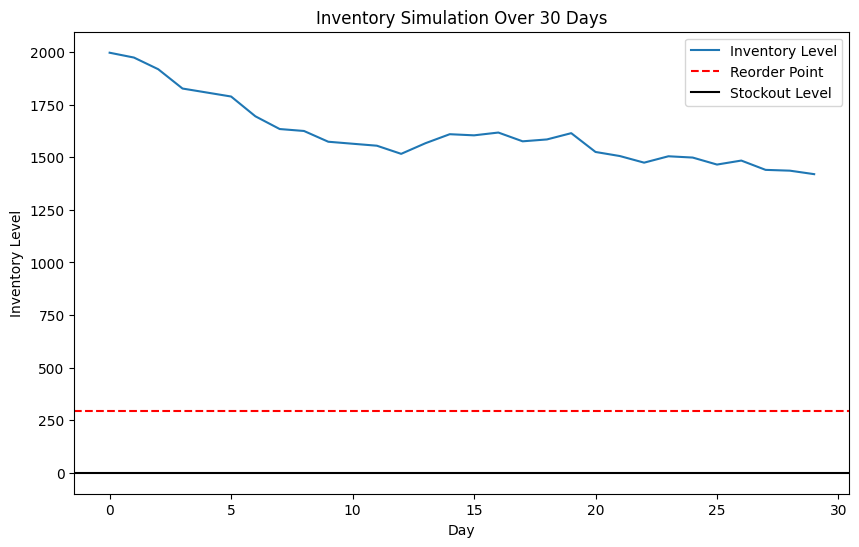

Stockouts in 30 days: 0


In [38]:
# Simulate inventory levels for 30 days
np.random.seed(42)
sim_days = 30
daily_demand_sim = np.random.normal(mean_demand, std_demand, sim_days)
inventory = Q
reorder_point = rop
stockouts = 0
inventory_levels = []

for demand in daily_demand_sim:
    inventory -= demand
    inventory_levels.append(inventory)

    if inventory < 0:
        stockouts += 1
        inventory = 0  # Assume emergency restock
    if inventory < reorder_point:
        inventory += Q  # Place order

# Plot inventory levels
plt.figure(figsize=(10, 6))
plt.plot(inventory_levels, label='Inventory Level')
plt.axhline(reorder_point, color='r', linestyle='--', label='Reorder Point')
plt.axhline(0, color='k', linestyle='-', label='Stockout Level')
plt.title('Inventory Simulation Over 30 Days')
plt.xlabel('Day')
plt.ylabel('Inventory Level')
plt.legend()
plt.show()

print(f"Stockouts in 30 days: {stockouts}")

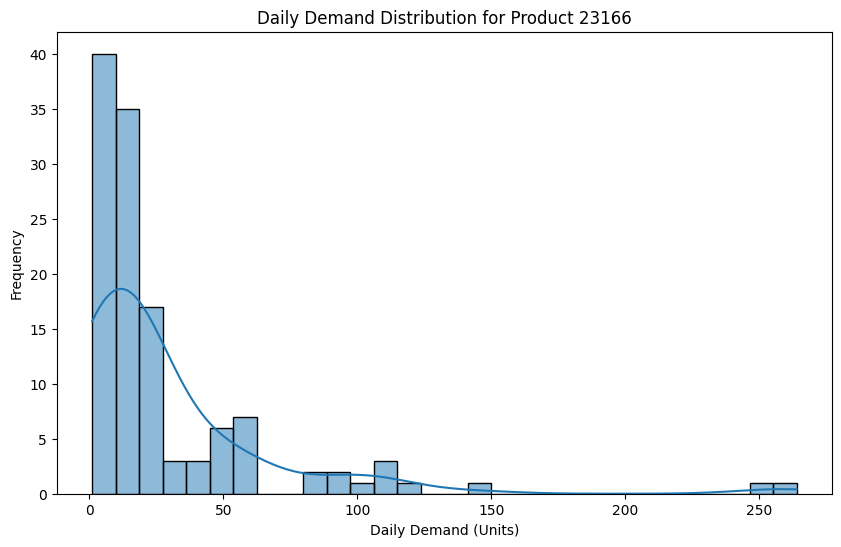

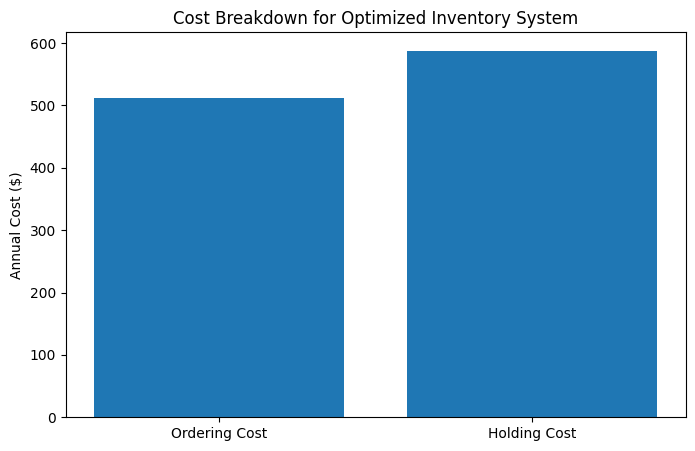

In [39]:
# Demand distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(product_data['Quantity'], bins=30, kde=True)
plt.title(f'Daily Demand Distribution for Product {top_product}')
plt.xlabel('Daily Demand (Units)')
plt.ylabel('Frequency')
plt.show()

# Cost breakdown
costs = {'Ordering Cost': ordering_cost, 'Holding Cost': holding_cost}
plt.figure(figsize=(8, 5))
plt.bar(costs.keys(), costs.values())
plt.title('Cost Breakdown for Optimized Inventory System')
plt.ylabel('Annual Cost ($)')
plt.show()